After designing and trainning a network that recieves 4 sensors reading in time and predicts the source's location, we will provide a different method.
The previous network acted as a statistical interpolator, it learned the connections between the sensors reading at a specific time t, to the location of the source. It didn't learned the solution to the waves equation.
We will now suggest a different approach, and design a network that will learn the solution to the waves equation and then use this solution to find the source location at time t=0.
Since we know that the solutions to the waves equation are eigen states of the fourier space, we suggest using a Fourier network (which also simplifies the equation as derivative in space domain transform to multipication in frequency domain).

FNO- Fourier Neural Operator:
CNNs are local, each pixel is being mixed with its neighbooring pixels in each layer, and as a conseqence of that, relationships between far away pixels in the input are discovered only in deep layers.
FNOs are global. They use FFT to convert the input into the frequency domain, where there is a connection between all pixels (not related to the distance between them in the original input).
We chose to use this kind of network beacuse solving waves equation in the frequency domain is easier than in spatial domain.
The fact that derivation and integration in spatial domain transform to multipication and division in the frequency domain also helps the network to learn with less noise (neural networks struggle to learn clean derivatives).
This way, instead of learning complex calculus, the model needs to learn a multipication matrix.

Our model will contain:
1. FFT layer -  a layer that recieves raw time data and preforms FFT on it.

In [6]:
#imports:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import torch.optim.lr_scheduler as lr_scheduler
import copy
import scipy.ndimage as ndimage

In [7]:
#data generator:

# --- 1. Physics Simulator (Single Source) ---
def generate_seismic_data(num_samples=5000, grid_size=32, velocity=300.0, noise_level=0.001):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Storage
    X_data = np.zeros((num_samples, 4, 200))
    source_coords = np.zeros((num_samples, 2))

    # Ricker Wavelet Setup
    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} Single-Source samples...")

    for i in range(num_samples):
        # Random Location
        src = np.random.rand(2) * [x_max, y_max]
        source_coords[i] = src

        # Simulate Physics
        for s in range(4):
            dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
            arrival_time = dist / velocity
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < 200:
                valid_len = 200 - shift_steps
                X_data[i, s, shift_steps:] = wavelet_base[:valid_len] * amplitude

        # Add Noise
        X_data[i] += np.random.normal(0, noise_level, (4, 200))

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_coords, dtype=torch.float32)

# --- 2. Target Generator (Heatmaps) ---
def create_gaussian_map(coords, grid_size=32, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(coords)):
        cx, cy = coords[i]
        gauss = np.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))
        maps.append(gauss)

    return np.array(maps)

In [8]:
#data normalization and splitting:
# --- 1. Generate Raw Data ---
X_raw, coords = generate_seismic_data(num_samples=6000, grid_size=32)
Y_raw = create_gaussian_map(coords.numpy(), grid_size=32)

# --- 2. Normalize ---
# Calculate max value for normalization
norm_factor = torch.max(torch.abs(X_raw))
print(f"Normalization Factor: {norm_factor:.4f}")

X_data = X_raw / norm_factor
Y_data = torch.tensor(Y_raw, dtype=torch.float32).unsqueeze(1) # Add channel dim [N, 1, 32, 32]

# --- 3. Split into Train/Val/Test ---
dataset = TensorDataset(X_data, Y_data)

# Sizes
train_size = int(0.7 * len(dataset))  # 4200
val_size   = int(0.15 * len(dataset)) # 900
test_size  = len(dataset) - train_size - val_size # 900

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Loaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Data Ready: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")

Generating 6000 Single-Source samples...
Normalization Factor: 0.8690
Data Ready: Train=4200, Val=900, Test=900


In [9]:
class EndToEndFourierNet(nn.Module):
    def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
        super(EndToEndFourierNet, self).__init__()
        self.grid_size = grid_size

        # 1. FFT Dimensions
        # rFFT of 200 points -> 101 freq modes
        self.freq_modes = time_steps // 2 + 1

        # Input to Linear: 4 sensors * 101 modes * 2 (Real/Imag parts)
        input_dim = num_sensors * self.freq_modes * 2

        # Output Dimensions: 32x32 Grid in Frequency Domain
        # rFFT of 32x32 image -> 32 * 17 complex numbers
        self.out_height = grid_size
        self.out_width_complex = grid_size // 2 + 1
        output_dim = self.out_height * self.out_width_complex * 2

        # 2. Spectral Mixer (The Brain)
        self.spectral_mapping = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # A. Internal FFT (Time -> Frequency)
        x_ft = torch.fft.rfft(x, dim=2)

        # B. Flatten & Stack Real/Imag
        x_flat = torch.cat([x_ft.real, x_ft.imag], dim=2).view(batch_size, -1)

        # C. Spectral Mixing (Physics Learning)
        x_spectral_out = self.spectral_mapping(x_flat)

        # D. Reshape & Inverse FFT (Frequency -> Space)
        x_spectral_out = x_spectral_out.view(batch_size, 2, self.out_height, self.out_width_complex)
        grid_freq = torch.complex(x_spectral_out[:, 0], x_spectral_out[:, 1])

        # Reconstruct the physical heatmap
        grid_spatial = torch.fft.irfft2(grid_freq, s=(self.grid_size, self.grid_size))

        return grid_spatial.unsqueeze(1) # [Batch, 1, 32, 32]

In [10]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fft = EndToEndFourierNet(num_sensors=4, time_steps=200, grid_size=32).to(device)

optimizer = optim.Adam(model_fft.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Training Fourier Net (Fixed FFT)...")
for epoch in range(20):
    model_fft.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_fft(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {running_loss / len(train_loader):.6f}")

print("Training Complete!")

Training Fourier Net (Fixed FFT)...
Epoch 1 | Loss: 0.014249
Epoch 2 | Loss: 0.004725
Epoch 3 | Loss: 0.002340
Epoch 4 | Loss: 0.001625
Epoch 5 | Loss: 0.001347
Epoch 6 | Loss: 0.001207
Epoch 7 | Loss: 0.001114
Epoch 8 | Loss: 0.001052
Epoch 9 | Loss: 0.001003
Epoch 10 | Loss: 0.000943
Epoch 11 | Loss: 0.000917
Epoch 12 | Loss: 0.000875
Epoch 13 | Loss: 0.000836
Epoch 14 | Loss: 0.000799
Epoch 15 | Loss: 0.000752
Epoch 16 | Loss: 0.000723
Epoch 17 | Loss: 0.000706
Epoch 18 | Loss: 0.000663
Epoch 19 | Loss: 0.000626
Epoch 20 | Loss: 0.000600
Training Complete!


In [11]:
#evaluation:

# --- 1. Helper: Find Peak (Brightest Pixel) ---
def get_peak_location(heatmap):
    """ Finds the (x, y) location of the brightest pixel in meters. """
    # 1. Find index of max value
    idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)

    # 2. Convert to meters (Grid is 100m x 100m, Size is 32x32)
    pixel_size = 100.0 / 32.0

    # idx[0] is Row (Y), idx[1] is Col (X)
    # Heatmap origin is usually top-left in arrays, but we treat it as cartesian
    pred_y = idx[0] * pixel_size
    pred_x = idx[1] * pixel_size

    return np.array([pred_x, pred_y])

# --- 2. Helper: Evaluate Dataset ---
def evaluate_model(model, loader, device, name="Test Set"):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # Predict
            outputs = model(inputs).cpu().numpy()
            targets = targets.cpu().numpy()

            for i in range(len(inputs)):
                # Get True & Pred Locations
                true_loc = get_peak_location(targets[i, 0])
                pred_loc = get_peak_location(outputs[i, 0])

                # Calculate Euclidean Distance
                dist = np.linalg.norm(true_loc - pred_loc)
                errors.append(dist)

    mean_err = np.mean(errors)
    median_err = np.median(errors)
    print(f"--- Results for {name} ---")
    print(f"Mean Error:   {mean_err:.4f} meters")
    print(f"Median Error: {median_err:.4f} meters")
    return errors

# --- 3. Helper: Visualize One Sample ---
def visualize_sample(model, loader, device, title="Prediction"):
    model.eval()
    x_test, y_test = next(iter(loader))
    x_test = x_test.to(device)

    with torch.no_grad():
        pred = model(x_test).cpu().numpy()

    # Pick the first sample in batch
    true_map = y_test[0, 0].cpu().numpy()
    pred_map = pred[0, 0]

    # Get Coords
    p_true = get_peak_location(true_map)
    p_pred = get_peak_location(pred_map)
    dist = np.linalg.norm(p_true - p_pred)

    # Plot
    plt.figure(figsize=(10, 4))

    # Truth
    plt.subplot(1, 2, 1)
    plt.imshow(true_map, origin='lower', extent=[0, 100, 0, 100])
    plt.title(f"True: ({p_true[0]:.1f}, {p_true[1]:.1f})")
    plt.colorbar()

    # Pred
    plt.subplot(1, 2, 2)
    plt.imshow(pred_map, origin='lower', extent=[0, 100, 0, 100])
    plt.title(f"Pred: ({p_pred[0]:.1f}, {p_pred[1]:.1f}) | Err: {dist:.1f}m")
    plt.colorbar()

    plt.suptitle(title)
    plt.show()

--- Results for Clean Test Set ---
Mean Error:   2.3810 meters
Median Error: 3.1250 meters


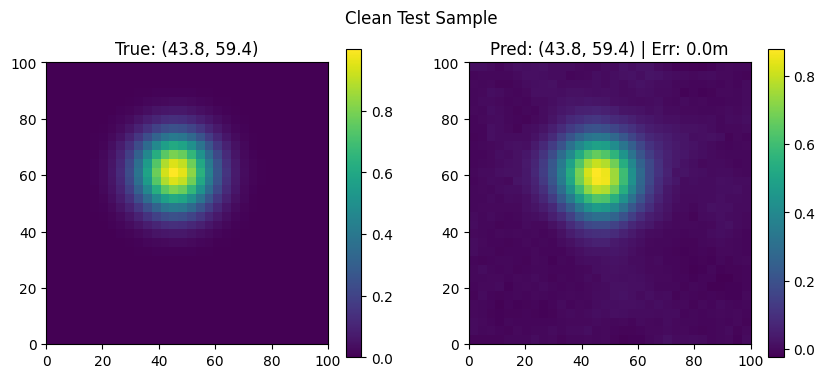

In [12]:
# Evaluate Clean Data
_ = evaluate_model(model_fft, test_loader, device, name="Clean Test Set")
visualize_sample(model_fft, test_loader, device, title="Clean Test Sample")


Generating Medium Noise Data (0.005)...
Generating 1000 Single-Source samples...
--- Results for Medium Noise Set ---
Mean Error:   3.1786 meters
Median Error: 3.1250 meters


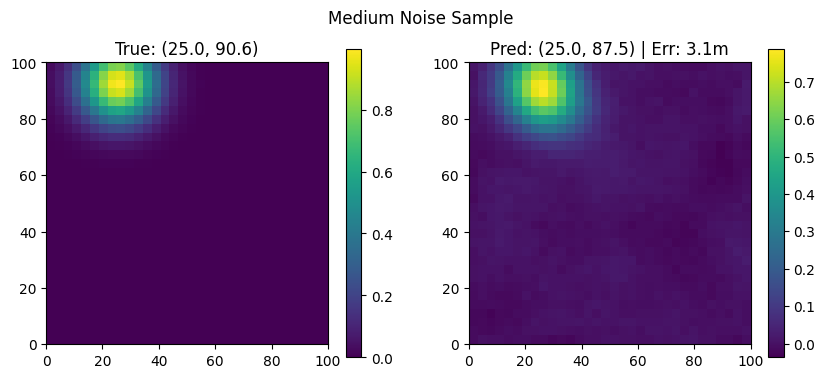

In [13]:
# --- 1. Generate Medium Noise Data ---
print("\nGenerating Medium Noise Data (0.005)...")
X_med_raw, coords_med = generate_seismic_data(
    num_samples=1000,
    grid_size=32,
    noise_level=0.005 # <--- Increased Noise
)
Y_med_raw = create_gaussian_map(coords_med.numpy(), grid_size=32)

# --- 2. Normalize (CRITICAL: Use Training Norm Factor) ---
# We must use the 'norm_factor' calculated in Step 2 of the previous notebook cell
X_med = X_med_raw / norm_factor
Y_med = torch.tensor(Y_med_raw, dtype=torch.float32).unsqueeze(1)

# --- 3. Create Loader ---
dataset_med = TensorDataset(X_med, Y_med)
loader_med = DataLoader(dataset_med, batch_size=64, shuffle=False)

# --- 4. Evaluate & Visualize ---
_ = evaluate_model(model_fft, loader_med, device, name="Medium Noise Set")
visualize_sample(model_fft, loader_med, device, title="Medium Noise Sample")

We can see that both for the test set and medium noise test set, we get a median error of 3.125m, which is exactly one pixel.
We understand that our Fourier transform usualy (for more than half of the samples) predicts the neighboring pixel of the true target pixel.
This may happen because Fourier transform represents position as phase shift. Therfore, if the network has a small error in the phase prediction it may lead to a bigger error in the location prediction.
The waves we have are limited in time which means they are multiplied by a window in the frequency domain that can cause ripples around the center of it, which may be causing the max function to choose the neighboring pixel.
The fact that the median of both test sets is the same, means that the model is quite robust to noise, and that it has a one pixel bias.
In this phase in the CNN we got higher error for the noisy set, and realised our network isn't robust to noise. In order to fix that, we used data augmentation (created a new data set with random velocities and noise levels). This time our network is generalizing well, but it has a bias.
We assume that the bias accures mainly because of the net's try to build our solution from inifinite sinus functions basis (which causes ripples).
We will try to eliminate the bias by using a second approach, a net that performs and learns the transform as well so it can learn a different basis.

In [14]:
class LearnableBasisNet(nn.Module):
    def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
        super(LearnableBasisNet, self).__init__()
        self.grid_size = grid_size
        self.time_steps = time_steps

        # --- 1. The Learnable "FFT" (Time -> Latent Freq) ---
        # Instead of fixed 101 freq modes, we let the net choose 'hidden_dim' modes
        self.hidden_dim = 128

        # This replaces the FFT. It learns the best way to decompose the signal.
        # Input: 200 time steps -> Output: 128 "Frequency" features
        self.learnable_transform = nn.Linear(time_steps, self.hidden_dim)

        # --- 2. Spectral Mixing (The Physics) ---
        # Input: 4 sensors * 128 modes
        input_dim = num_sensors * self.hidden_dim

        # We process in this latent space
        self.spectral_mixer = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            # Output: We map to a flattened image dimension directly
            nn.Linear(2048, grid_size * grid_size)
        )

        # Note: We don't need an explicit "Inverse Transform" layer because
        # the last Linear layer maps directly to pixels (Spatial Domain).
        # This is mathematically equivalent to Mixing + Inverse Transform combined.

    def forward(self, x):
        # x shape: [Batch, 4, 200]
        batch_size = x.size(0)

        # --- Step 1: Learnable Transform ---
        # We apply the transform to each sensor independently
        # View as [Batch * 4, 200]
        x_flat = x.view(-1, self.time_steps)

        # Transform! (The network invents its own "frequencies")
        x_freq = self.learnable_transform(x_flat)
        x_freq = torch.relu(x_freq) # Nonlinearity helps learn complex bases

        # --- Step 2: Mixing ---
        # Reshape to [Batch, 4 * 128]
        x_freq = x_freq.view(batch_size, -1)

        # Mix and Predict Spatial Map
        x_spatial = self.spectral_mixer(x_freq)

        # --- Step 3: Reshape to Image ---
        output_map = x_spatial.view(batch_size, 1, self.grid_size, self.grid_size)

        return output_map

# --- Initialize ---
model_learnable = LearnableBasisNet(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer_learn = optim.Adam(model_learnable.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Initialized Learnable Basis Network.")

Initialized Learnable Basis Network.


In [15]:
print("Training Approach 2: Learnable Basis...")
loss_history = []

for epoch in range(20):
    model_learnable.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_learn.zero_grad()
        outputs = model_learnable(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_learn.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

Training Approach 2: Learnable Basis...
Epoch 1 | Loss: 0.019732
Epoch 2 | Loss: 0.007812
Epoch 3 | Loss: 0.003586
Epoch 4 | Loss: 0.002155
Epoch 5 | Loss: 0.001589
Epoch 6 | Loss: 0.001346
Epoch 7 | Loss: 0.001170
Epoch 8 | Loss: 0.001031
Epoch 9 | Loss: 0.000929
Epoch 10 | Loss: 0.000881
Epoch 11 | Loss: 0.000815
Epoch 12 | Loss: 0.000782
Epoch 13 | Loss: 0.000718
Epoch 14 | Loss: 0.000662
Epoch 15 | Loss: 0.000604
Epoch 16 | Loss: 0.000585
Epoch 17 | Loss: 0.000550
Epoch 18 | Loss: 0.000502
Epoch 19 | Loss: 0.000492
Epoch 20 | Loss: 0.000457


In [16]:
# Evaluate
print("\n--- Comparing Approaches ---")
_ = evaluate_model(model_learnable, test_loader, device, name="Learnable Net (Clean)")
_ = evaluate_model(model_learnable, loader_med, device, name="Learnable Net (Medium Noise)")


--- Comparing Approaches ---
--- Results for Learnable Net (Clean) ---
Mean Error:   1.6814 meters
Median Error: 0.0000 meters
--- Results for Learnable Net (Medium Noise) ---
Mean Error:   3.4804 meters
Median Error: 3.1250 meters


We can see that the clean test set median error is now 0, which means the model successfuly learned a better basis for the problem, which we will show in the next code snippet.
Although the model successfuly eliminated the bias on the clean data set, it is now overfitting it. The model's error on clean data improved (since it "memorized" the structure of a clean wave) but didn't improve on noisy data.

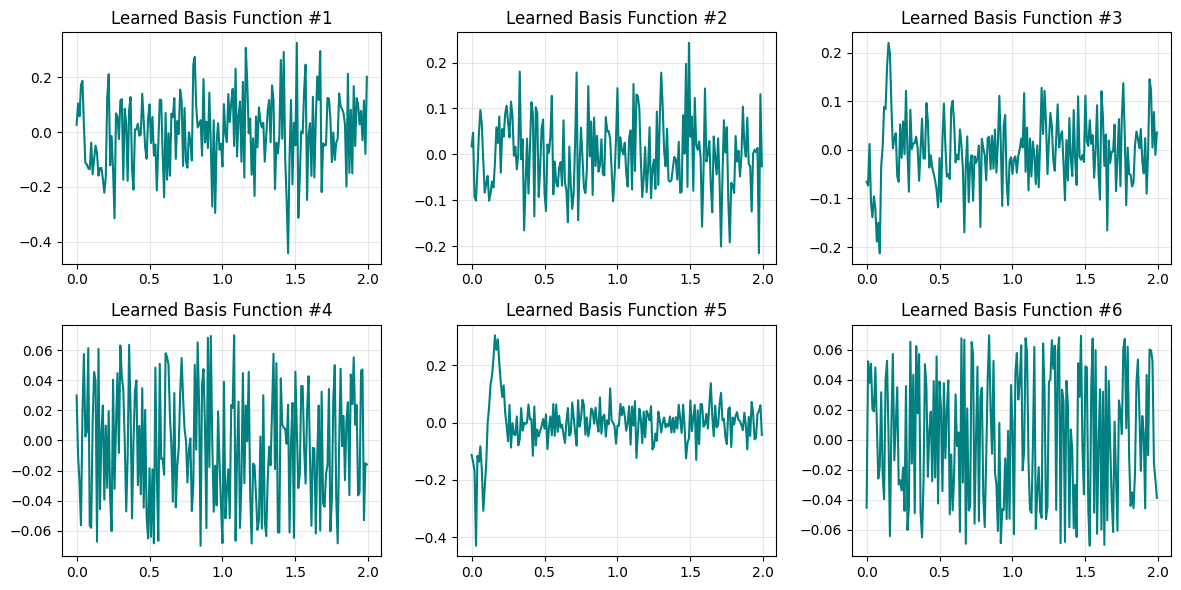

In [17]:
def visualize_learned_basis(model, num_plots=6):
    # Extract the weights from the transform layer
    # Shape: [Hidden_Dim, Time_Steps] (e.g., 128 x 200)
    weights = model.learnable_transform.weight.data.cpu().numpy()

    t = np.arange(200) * 0.01

    plt.figure(figsize=(12, 6))

    # Plot the first 'num_plots' learned functions
    for i in range(num_plots):
        plt.subplot(2, 3, i+1)
        plt.plot(t, weights[i], color='teal')
        plt.title(f"Learned Basis Function #{i+1}")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run it
visualize_learned_basis(model_learnable)

We can now visualy see that the new basis functions the model learned are very similar to the waves we plotted on the previous model after generating the data (which is exactly the same here).
Now we will try to fight the overfit using data augmentation, this time we will do it by injecting noise to the model during training.

In [18]:
# --- Re-Initialize Model (Start Fresh) ---
model_robust_basis = LearnableBasisNet(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer_rob = optim.Adam(model_robust_basis.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Retraining Learnable Basis with Noise Augmentation...")

# We train for slightly longer (25 epochs) because the problem is harder now
loss_history = []

for epoch in range(25):
    model_robust_basis.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # --- DATA AUGMENTATION (On-the-fly) ---
        # Add random noise to every batch.
        # We use 0.005 (Medium Noise) to force it to learn robustness.
        noise = torch.randn_like(inputs) * 0.005
        noisy_inputs = inputs + noise

        optimizer_rob.zero_grad()
        # Train on NOISY data
        outputs = model_robust_basis(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

print("Robust Training Complete.")

Retraining Learnable Basis with Noise Augmentation...
Epoch 5 | Loss: 0.001787
Epoch 10 | Loss: 0.001207
Epoch 15 | Loss: 0.001042
Epoch 20 | Loss: 0.000971
Epoch 25 | Loss: 0.000965
Robust Training Complete.


In [19]:
print("\n--- Final Robustness Check ---")
_ = evaluate_model(model_robust_basis, test_loader, device, name="Robust Basis (Clean)")
_ = evaluate_model(model_robust_basis, loader_med, device, name="Robust Basis (Medium Noise)")


--- Final Robustness Check ---
--- Results for Robust Basis (Clean) ---
Mean Error:   2.1656 meters
Median Error: 3.1250 meters
--- Results for Robust Basis (Medium Noise) ---
Mean Error:   2.6175 meters
Median Error: 3.1250 meters


Our model now does get better performance on the noisy test set, but its performance on the clean test set deteriorited.
We will try to improve our model accuracy by adding velocity augmentation (like before, generate data with random velocities). This changes the wave structure by compessing or streching the signal in time (scaling), which force the model to choose a basis that contain more flexible functions- should improve both robustness and accuracy.
We will also add layer normalization, which should alow the model to keep sharp peaks in the wave even when handeling noise.
We also added dropout layers to prevent the model from overfitting.

In [20]:
#upgraded model:
class LearnableBasisNet_Pro(nn.Module):
    def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
        super(LearnableBasisNet_Pro, self).__init__()
        self.grid_size = grid_size
        self.time_steps = time_steps

        # Increased capacity for the basis (128 -> 256)
        self.hidden_dim = 256

        # 1. Learnable Transform
        self.learnable_transform = nn.Linear(time_steps, self.hidden_dim)

        # 2. Spectral Mixer (Deep + LayerNorm)
        # LayerNorm helps the model keep values "sharp" and stable
        input_dim = num_sensors * self.hidden_dim

        self.spectral_mixer = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.LayerNorm(2048),   # <--- NEW: Normalization
            nn.ReLU(),
            nn.Dropout(0.2),      # <--- NEW: Prevents overfitting to specific features

            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),   # <--- NEW: Normalization
            nn.ReLU(),

            # Extra layer for refinement
            nn.Linear(2048, 1024),
            nn.ReLU(),

            nn.Linear(1024, grid_size * grid_size)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(-1, self.time_steps)

        x_freq = self.learnable_transform(x_flat)
        x_freq = torch.relu(x_freq)

        x_freq = x_freq.view(batch_size, -1)
        x_spatial = self.spectral_mixer(x_freq)

        output_map = x_spatial.view(batch_size, 1, self.grid_size, self.grid_size)
        return output_map

We want to generate data with random velocity while training the model.
Since the training loop is slow, we will pre-generate a pool of diverse physics data and mix it.

In [21]:
# --- Generate Diverse Training Data (Velocity varies) ---
def generate_diverse_data(num_samples=5000, grid_size=32):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    X_data = np.zeros((num_samples, 4, 200))
    coords = np.zeros((num_samples, 2))

    # Ricker Wavelet (Pre-calc)
    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} Diverse Physics samples...")

    for i in range(num_samples):
        # 1. Random Location
        src = np.random.rand(2) * [x_max, y_max]
        coords[i] = src

        # 2. RANDOM VELOCITY (Augmentation)
        # Varies between 280 m/s and 320 m/s
        vel = 280 + np.random.rand() * 40

        for s in range(4):
            dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
            arrival_time = dist / vel
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < 200:
                valid_len = 200 - shift_steps
                X_data[i, s, shift_steps:] = wavelet_base[:valid_len] * amplitude

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(coords, dtype=torch.float32)

# Generate new diverse data
X_div_raw, coords_div = generate_diverse_data(num_samples=5000)
Y_div_raw = create_gaussian_map(coords_div.numpy(), grid_size=32)

# Normalize
X_div = X_div_raw / norm_factor # Keep original norm factor to handle amplitude shifts
Y_div = torch.tensor(Y_div_raw, dtype=torch.float32).unsqueeze(1)

# Loader
train_loader_div = DataLoader(TensorDataset(X_div, Y_div), batch_size=64, shuffle=True)

Generating 5000 Diverse Physics samples...


In an other attempt to improve the model's accuracy, we will treat the number of epochs as an hyper-parameter and use the validation set to pick the optimized number of epochs to run.


In [22]:
import copy # Needed to deep copy the best weights

# --- Configuration ---
patience = 5
trigger_times = 0
best_val_loss = float('inf')
best_model_weights = None

# Initialize Model (Pro version)
model_pro = LearnableBasisNet_Pro(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer_pro = optim.Adam(model_pro.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(f"Training with Early Stopping (Patience={patience})...")

for epoch in range(50): # We set a high max, relying on Early Stopping to finish it
    # --- 1. Training Phase ---
    model_pro.train()
    train_loss = 0.0

    for inputs, targets in train_loader_div:
        inputs, targets = inputs.to(device), targets.to(device)

        # Noise Augmentation
        noise = torch.randn_like(inputs) * 0.003
        noisy_inputs = inputs + noise

        optimizer_pro.zero_grad()
        outputs = model_pro(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pro.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_div)

    # --- 2. Validation Phase ---
    model_pro.eval()
    val_loss = 0.0
    with torch.no_grad():
        for v_in, v_out in val_loader:
            v_in, v_out = v_in.to(device), v_out.to(device)
            val_pred = model_pro(v_in)
            val_loss += criterion(val_pred, v_out).item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}", end="")

    # --- 3. Early Stopping Logic ---
    if avg_val_loss < best_val_loss:
        # Improved! Save state and reset trigger
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model_pro.state_dict())
        trigger_times = 0
        print(" [Saved Best]")
    else:
        # No improvement
        trigger_times += 1
        print(f" [No Improv: {trigger_times}/{patience}]")

        if trigger_times >= patience:
            print(f"\nEarly Stopping triggered! Stopping at epoch {epoch+1}.")
            break

# --- 4. Load the Best Weights ---
model_pro.load_state_dict(best_model_weights)
print("Best model loaded.")

Training with Early Stopping (Patience=5)...
Epoch 1 | Train Loss: 0.024789 | Val Loss: 0.022093 [Saved Best]
Epoch 2 | Train Loss: 0.021529 | Val Loss: 0.021073 [Saved Best]
Epoch 3 | Train Loss: 0.020913 | Val Loss: 0.020731 [Saved Best]
Epoch 4 | Train Loss: 0.020739 | Val Loss: 0.020889 [No Improv: 1/5]
Epoch 5 | Train Loss: 0.020621 | Val Loss: 0.020578 [Saved Best]
Epoch 6 | Train Loss: 0.020553 | Val Loss: 0.020518 [Saved Best]
Epoch 7 | Train Loss: 0.020482 | Val Loss: 0.020503 [Saved Best]
Epoch 8 | Train Loss: 0.020468 | Val Loss: 0.020466 [Saved Best]
Epoch 9 | Train Loss: 0.020393 | Val Loss: 0.020391 [Saved Best]
Epoch 10 | Train Loss: 0.020360 | Val Loss: 0.020393 [No Improv: 1/5]
Epoch 11 | Train Loss: 0.020361 | Val Loss: 0.020393 [No Improv: 2/5]
Epoch 12 | Train Loss: 0.020344 | Val Loss: 0.020352 [Saved Best]
Epoch 13 | Train Loss: 0.020346 | Val Loss: 0.020346 [Saved Best]
Epoch 14 | Train Loss: 0.020329 | Val Loss: 0.020335 [Saved Best]
Epoch 15 | Train Loss: 0.020

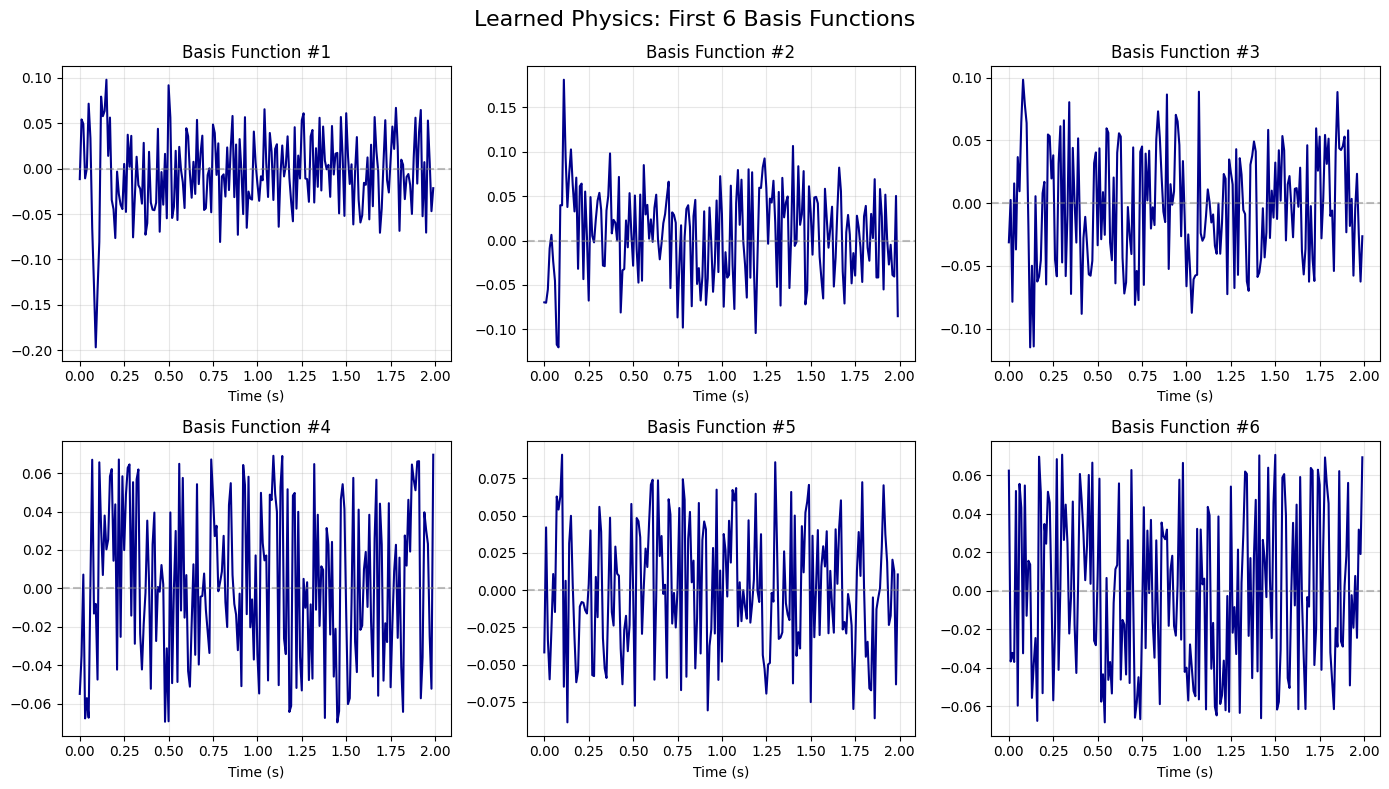

In [23]:

def visualize_pro_basis(model, num_plots=6):
    """
    Visualizes the learned basis functions (rows of the transform matrix)
    from the 'LearnableBasisNet_Pro' model.
    """
    # 1. Extract weights
    # The shape is [Hidden_Dim, Time_Steps] (e.g., 256 x 200)
    # Each row acts like a correlation filter (a custom wavelet)
    weights = model.learnable_transform.weight.data.cpu().numpy()

    # Time axis (0 to 2 seconds)
    t = np.arange(200) * 0.01

    # 2. Plot
    plt.figure(figsize=(14, 8))

    # We plot the first 'num_plots' filters
    # You can change the slice (e.g., weights[10:16]) to see deeper filters
    for i in range(num_plots):
        plt.subplot(2, 3, i+1)

        # Plot the wave
        plt.plot(t, weights[i], color='darkblue', linewidth=1.5)

        # Add zero line for reference
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)

        plt.title(f"Basis Function #{i+1}")
        plt.xlabel("Time (s)")
        plt.grid(True, alpha=0.3)

    plt.suptitle(f"Learned Physics: First {num_plots} Basis Functions", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Run Visualization ---
visualize_pro_basis(model_pro, num_plots=6)

In [24]:
print("\n--- Final Pro Model Results ---")
_ = evaluate_model(model_pro, test_loader, device, name="Pro Net (Clean)")
_ = evaluate_model(model_pro, loader_med, device, name="Pro Net (Medium Noise)")


--- Final Pro Model Results ---
--- Results for Pro Net (Clean) ---
Mean Error:   31.3251 meters
Median Error: 27.9508 meters
--- Results for Pro Net (Medium Noise) ---
Mean Error:   31.3790 meters
Median Error: 28.8111 meters


We expected better performance, but recieved way higher errors.
We suspect that this may happen because of the dropout. While usualy helping to generalize the model, in this specific task, using dropout may harm the model's learning because it "delets" parts of the continous wave during training.
Let's try our improved model without this part.
We will also delete the normalization (practicly use the improved training with random data and early stopping on the previous model) because it changes the amplitude of the wave, making it harder for the model to learn the distance from the sensors.

In [25]:
# --- 1. Define the SIMPLE Architecture (No Dropout, No Norm) ---
class LearnableBasisNet_Simple(nn.Module):
    def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
        super(LearnableBasisNet_Simple, self).__init__()
        self.grid_size = grid_size
        self.time_steps = time_steps

        # We stick to the standard capacity
        self.hidden_dim = 128
        self.learnable_transform = nn.Linear(time_steps, self.hidden_dim)

        input_dim = num_sensors * self.hidden_dim

        # Pure Linear Mixing - The "Cleanest" path for physics
        self.spectral_mixer = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, grid_size * grid_size)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(-1, self.time_steps)

        # Learnable Transform
        x_freq = self.learnable_transform(x_flat)
        x_freq = torch.relu(x_freq)

        # Mixing
        x_freq = x_freq.view(batch_size, -1)
        x_spatial = self.spectral_mixer(x_freq)

        # Output
        output_map = x_spatial.view(batch_size, 1, self.grid_size, self.grid_size)
        return output_map

# --- 2. Train on DIVERSE Data (With Early Stopping) ---
import copy

# Initialize
model_final = LearnableBasisNet_Simple(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer = optim.Adam(model_final.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early Stopping Config
patience = 8  # Increased slightly to allow for noise fluctuations
trigger_times = 0
best_val_loss = float('inf')
best_weights = None

print("Training Simple Model on Diverse Physics Data...")

for epoch in range(50):
    model_final.train()
    running_loss = 0.0

    # Train on the 'train_loader_div' (Random Velocities)
    for inputs, targets in train_loader_div:
        inputs, targets = inputs.to(device), targets.to(device)

        # Light noise injection to help robustness
        noisy_inputs = inputs + (torch.randn_like(inputs) * 0.002)

        optimizer.zero_grad()
        outputs = model_final(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation (On Clean Data)
    model_final.eval()
    val_loss = 0.0
    with torch.no_grad():
        for v_in, v_out in val_loader:
            v_in, v_out = v_in.to(device), v_out.to(device)
            val_pred = model_final(v_in)
            val_loss += criterion(val_pred, v_out).item()

    avg_train = running_loss / len(train_loader_div)
    avg_val = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train: {avg_train:.6f} | Val: {avg_val:.6f}", end="")

    # Early Stopping Logic
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        best_weights = copy.deepcopy(model_final.state_dict())
        trigger_times = 0
        print(" [Saved Best]")
    else:
        trigger_times += 1
        print(f" [No Improv: {trigger_times}/{patience}]")
        if trigger_times >= patience:
            print(f"\nEarly Stopping triggered at Epoch {epoch+1}")
            break

# --- 3. Final Test ---
if best_weights is not None:
    model_final.load_state_dict(best_weights)
    print("\nLoaded Best Weights.")

print("\n--- Final Results (Simple Arch + Diverse Data) ---")
_ = evaluate_model(model_final, test_loader, device, name="Clean Test Set")
_ = evaluate_model(model_final, loader_med, device, name="Medium Noise Set")

Training Simple Model on Diverse Physics Data...
Epoch 1 | Train: 0.018290 | Val: 0.009858 [Saved Best]
Epoch 2 | Train: 0.005924 | Val: 0.004256 [Saved Best]
Epoch 3 | Train: 0.002788 | Val: 0.002260 [Saved Best]
Epoch 4 | Train: 0.001920 | Val: 0.001822 [Saved Best]
Epoch 5 | Train: 0.001586 | Val: 0.001530 [Saved Best]
Epoch 6 | Train: 0.001462 | Val: 0.001347 [Saved Best]
Epoch 7 | Train: 0.001270 | Val: 0.001300 [Saved Best]
Epoch 8 | Train: 0.001197 | Val: 0.001107 [Saved Best]
Epoch 9 | Train: 0.001073 | Val: 0.000978 [Saved Best]
Epoch 10 | Train: 0.000977 | Val: 0.000951 [Saved Best]
Epoch 11 | Train: 0.000972 | Val: 0.000888 [Saved Best]
Epoch 12 | Train: 0.000915 | Val: 0.000968 [No Improv: 1/8]
Epoch 13 | Train: 0.000870 | Val: 0.000874 [Saved Best]
Epoch 14 | Train: 0.000858 | Val: 0.000716 [Saved Best]
Epoch 15 | Train: 0.000818 | Val: 0.001116 [No Improv: 1/8]
Epoch 16 | Train: 0.000797 | Val: 0.000701 [Saved Best]
Epoch 17 | Train: 0.000738 | Val: 0.000689 [Saved Best]


We can see that we got our median error on the clean test set to get to 0 again, which means we got rid of the bias, and our model predicts the correct pixel for more than half of the samples in the clean test set. The mean error of this test set is also the lowest we got until now.
The median error of the noisy test set is still one pixel, and the mean error is slightly higher than we got before, our model is still overfitting.
We will now attempt to make our model even better using the "warm-up" method, in which we start with a relatively high learning rate and then decrease it, until we choose an other high value and so on. This method prevents the model from "getting stuck" in a local minima and try to find the global one.

In [26]:

# --- Setup ---
model_final = LearnableBasisNet_Simple(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer = optim.Adam(model_final.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Scheduler: Warm Restarts every 10 epochs
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

# History Vectors (To store values for plotting)
history = {
    'train_loss': [],
    'val_loss': [],
    'val_error_meters': [] # We will calculate actual distance error for validation
}

# Early Stopping Config
patience = 15
trigger_times = 0
best_val_loss = float('inf')
best_weights = None

print("Training with History Tracking & Warm Restarts...")

for epoch in range(50):
    # --- 1. Training Phase (Augmented Data) ---
    model_final.train()
    running_loss = 0.0

    for inputs, targets in train_loader_div: # Using DIVERSE data
        inputs, targets = inputs.to(device), targets.to(device)

        # Noise Augmentation
        noisy_inputs = inputs + (torch.randn_like(inputs) * 0.002)

        optimizer.zero_grad()
        outputs = model_final(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Update Learning Rate
    scheduler.step()

    # --- 2. Validation Phase (Metric Calculation) ---
    model_final.eval()
    val_loss = 0.0
    val_distances = []

    with torch.no_grad():
        for v_in, v_out in val_loader:
            v_in, v_out = v_in.to(device), v_out.to(device)
            val_pred = model_final(v_in)

            # Loss (MSE)
            val_loss += criterion(val_pred, v_out).item()

            # Distance Error (Meters) - Calculate for every batch
            # We assume batch size 64. We iterate through samples to get mean dist.
            v_out_np = v_out.cpu().numpy()
            v_pred_np = val_pred.cpu().numpy()

            for i in range(len(v_in)):
                true_loc = get_peak_location(v_out_np[i, 0])
                pred_loc = get_peak_location(v_pred_np[i, 0])
                dist = np.linalg.norm(true_loc - pred_loc)
                val_distances.append(dist)

    avg_train_loss = running_loss / len(train_loader_div)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dist = np.mean(val_distances)

    # Store in History
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_error_meters'].append(avg_val_dist)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.5f} | Val Dist: {avg_val_dist:.2f}m", end="")

    # --- 3. Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model_final.state_dict())
        trigger_times = 0
        print(" [Saved Best]")
    else:
        trigger_times += 1
        print(f" [No Improv: {trigger_times}]")
        if trigger_times >= patience:
            print(f"\nEarly Stopping triggered at Epoch {epoch+1}")
            break

# Load Best Weights
if best_weights is not None:
    model_final.load_state_dict(best_weights)

Training with History Tracking & Warm Restarts...
Epoch 1 | Train Loss: 0.01764 | Val Dist: 6.85m [Saved Best]
Epoch 2 | Train Loss: 0.00554 | Val Dist: 3.74m [Saved Best]
Epoch 3 | Train Loss: 0.00265 | Val Dist: 3.04m [Saved Best]
Epoch 4 | Train Loss: 0.00189 | Val Dist: 2.87m [Saved Best]
Epoch 5 | Train Loss: 0.00151 | Val Dist: 2.75m [Saved Best]
Epoch 6 | Train Loss: 0.00130 | Val Dist: 2.65m [Saved Best]
Epoch 7 | Train Loss: 0.00118 | Val Dist: 2.56m [Saved Best]
Epoch 8 | Train Loss: 0.00108 | Val Dist: 2.55m [Saved Best]
Epoch 9 | Train Loss: 0.00102 | Val Dist: 2.51m [Saved Best]
Epoch 10 | Train Loss: 0.00099 | Val Dist: 2.52m [Saved Best]
Epoch 11 | Train Loss: 0.00135 | Val Dist: 2.64m [No Improv: 1]
Epoch 12 | Train Loss: 0.00116 | Val Dist: 2.38m [No Improv: 2]
Epoch 13 | Train Loss: 0.00105 | Val Dist: 2.26m [No Improv: 3]
Epoch 14 | Train Loss: 0.00094 | Val Dist: 2.18m [Saved Best]
Epoch 15 | Train Loss: 0.00092 | Val Dist: 2.14m [Saved Best]
Epoch 16 | Train Loss: 

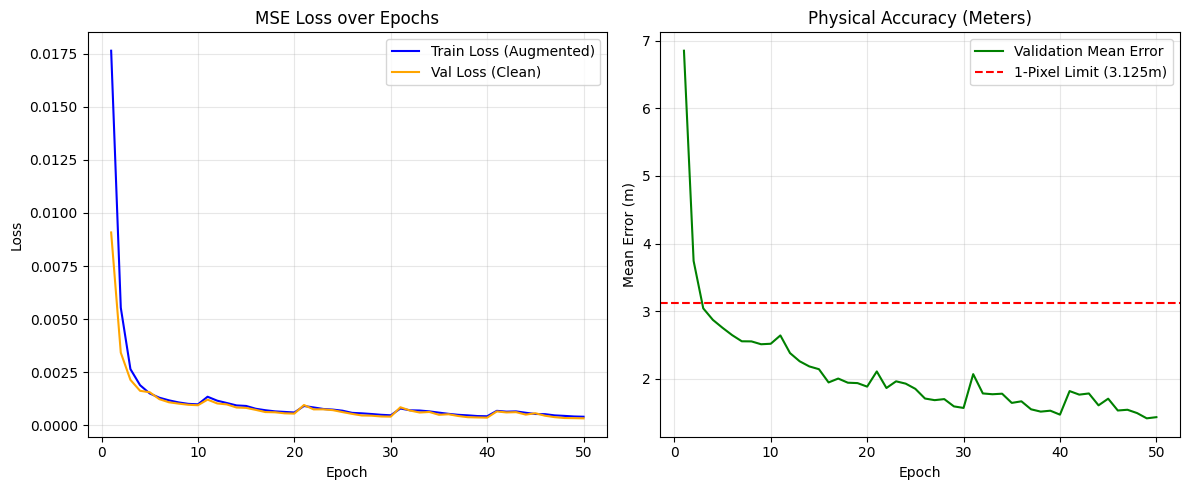


--- Final Unseen Test Set Results ---
--- Results for Test Set ---
Mean Error:   1.3581 meters
Median Error: 0.0000 meters
--- Results for Medium Noise Set ---
Mean Error:   3.0385 meters
Median Error: 3.1250 meters


In [27]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot 1: MSE Loss (Math)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss (Augmented)', color='blue')
    plt.plot(epochs, history['val_loss'], label='Val Loss (Clean)', color='orange')
    plt.title("MSE Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Physical Error (Meters)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_error_meters'], label='Validation Mean Error', color='green')
    plt.title("Physical Accuracy (Meters)")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Error (m)")
    plt.axhline(3.125, color='red', linestyle='--', label='1-Pixel Limit (3.125m)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run Plotting
plot_training_history(history)

# Final Test on the "Forbidden" Test Set (Only done once at the end!)
print("\n--- Final Unseen Test Set Results ---")
_ = evaluate_model(model_final, test_loader, device, name="Test Set")
_ = evaluate_model(model_final, loader_med, device, name="Medium Noise Set")

Since we got median error 0 for our clean test set, the model learned the best basis for this question.
Lets plot the functions to see it:

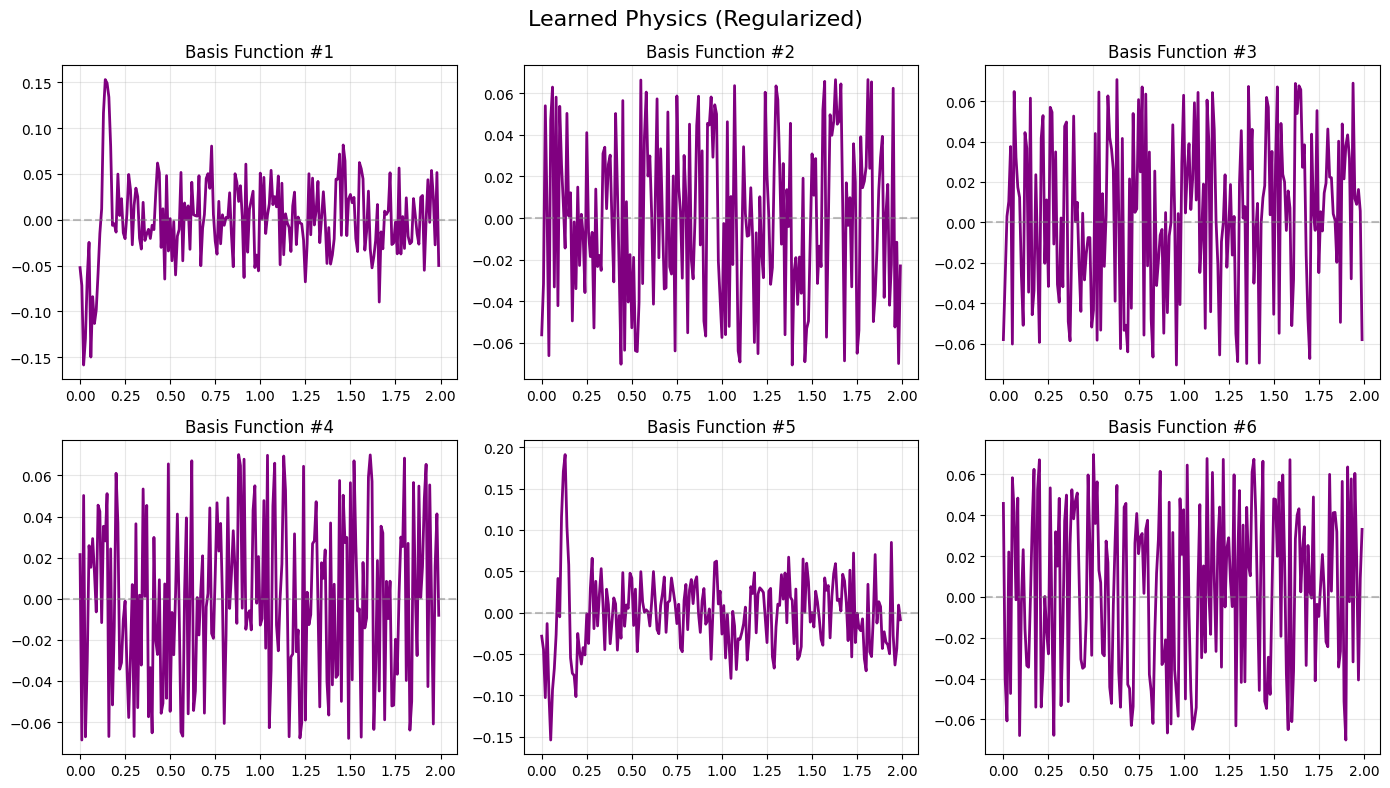

In [28]:
def visualize_basis(model, num_plots=6):
    # Extract weights: [Hidden_Dim, Time_Steps]
    weights = model.learnable_transform.weight.data.cpu().numpy()
    t = np.arange(200) * 0.01

    plt.figure(figsize=(14, 8))
    for i in range(num_plots):
        plt.subplot(2, 3, i+1)
        # Plot the wave
        plt.plot(t, weights[i], color='purple', linewidth=2)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.title(f"Basis Function #{i+1}")
        plt.grid(True, alpha=0.3)

    plt.suptitle("Learned Physics (Regularized)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run this AFTER training
visualize_basis(model_final)

We would like to try one last improvment.
We saw that dropout "broke" our model, and that our model is still overfitting. We would like to try a different way to use regularization with l2 regularization.
Also, our model with the warm-up didn't stop early (it kept improving although slower at the end) we will increase the maximial number of epochs to 80.

Training: Simple Arch + Augmentation + Warmup + L2 Regularization...
Epoch 1 | LR: 0.00098 | Val Dist: 8.43m [Saved Best]
Epoch 2 | LR: 0.00090 | Val Dist: 4.14m [Saved Best]
Epoch 3 | LR: 0.00079 | Val Dist: 3.75m [Saved Best]
Epoch 4 | LR: 0.00065 | Val Dist: 3.25m [Saved Best]
Epoch 5 | LR: 0.00050 | Val Dist: 3.40m [Saved Best]
Epoch 6 | LR: 0.00035 | Val Dist: 3.06m [Saved Best]
Epoch 7 | LR: 0.00021 | Val Dist: 2.94m [Saved Best]
Epoch 8 | LR: 0.00010 | Val Dist: 2.92m [Saved Best]
Epoch 9 | LR: 0.00002 | Val Dist: 2.90m [Saved Best]
Epoch 10 | LR: 0.00100 | Val Dist: 2.86m [Saved Best]
Epoch 11 | LR: 0.00098 | Val Dist: 3.16m [No Improv: 1]
Epoch 12 | LR: 0.00090 | Val Dist: 3.13m [No Improv: 2]
Epoch 13 | LR: 0.00079 | Val Dist: 3.06m [No Improv: 3]
Epoch 14 | LR: 0.00065 | Val Dist: 3.02m [No Improv: 4]
Epoch 15 | LR: 0.00050 | Val Dist: 2.83m [No Improv: 5]
Epoch 16 | LR: 0.00035 | Val Dist: 2.86m [No Improv: 6]
Epoch 17 | LR: 0.00021 | Val Dist: 2.78m [Saved Best]
Epoch 18 |

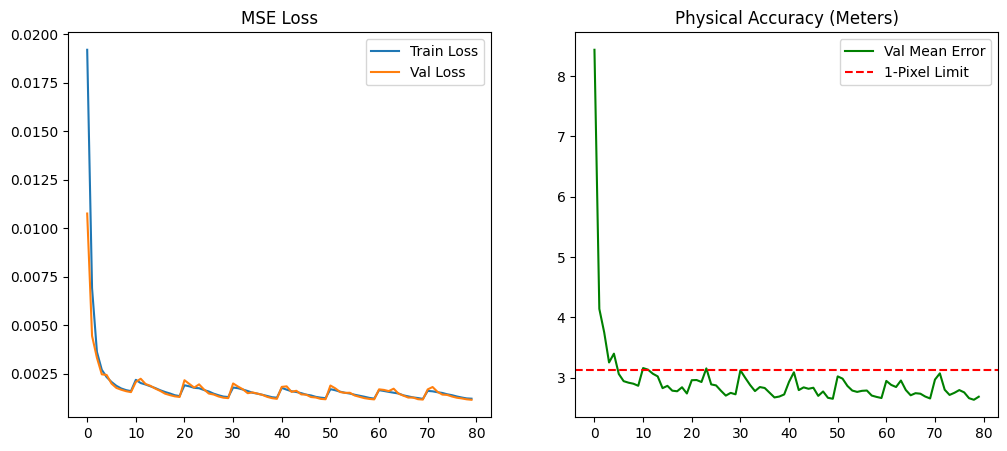


--- Final Results (Augmentation + Warmup + L2) ---
--- Results for Clean Test Set ---
Mean Error:   2.5583 meters
Median Error: 3.1250 meters
--- Results for Medium Noise Set ---
Mean Error:   3.0881 meters
Median Error: 3.1250 meters


In [29]:

# --- 1. Setup ---
# We use the Simple model (Proven best)
model_final = LearnableBasisNet_Simple(num_sensors=4, time_steps=200, grid_size=32).to(device)

# OPTIMIZER CHANGE: Added 'weight_decay' (L2 Regularization)
# 1e-5 is a safe starting point. It smooths the basis functions.
optimizer = optim.Adam(model_final.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Scheduler: Warm Restarts every 10 epochs
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

# History Storage
history = {'train_loss': [], 'val_loss': [], 'val_error_meters': []}

# Early Stopping Config
patience = 15 # High patience to allow for Warmup cycles
trigger_times = 0
best_val_loss = float('inf')
best_weights = None

print("Training: Simple Arch + Augmentation + Warmup + L2 Regularization...")

for epoch in range(80):
    # --- Training Phase ---
    model_final.train()
    running_loss = 0.0

    for inputs, targets in train_loader_div:
        inputs, targets = inputs.to(device), targets.to(device)

        # Noise Augmentation
        noisy_inputs = inputs + (torch.randn_like(inputs) * 0.002)

        optimizer.zero_grad()
        outputs = model_final(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Step the Scheduler (Warmup Logic)
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # --- Validation Phase ---
    model_final.eval()
    val_loss = 0.0
    val_distances = []

    with torch.no_grad():
        for v_in, v_out in val_loader:
            v_in, v_out = v_in.to(device), v_out.to(device)
            val_pred = model_final(v_in)

            # Loss
            val_loss += criterion(val_pred, v_out).item()

            # Meter Error Calculation
            v_out_np = v_out.cpu().numpy()
            v_pred_np = val_pred.cpu().numpy()
            for i in range(len(v_in)):
                true_loc = get_peak_location(v_out_np[i, 0])
                pred_loc = get_peak_location(v_pred_np[i, 0])
                val_distances.append(np.linalg.norm(true_loc - pred_loc))

    avg_train_loss = running_loss / len(train_loader_div)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dist = np.mean(val_distances)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_error_meters'].append(avg_val_dist)

    print(f"Epoch {epoch+1} | LR: {current_lr:.5f} | Val Dist: {avg_val_dist:.2f}m", end="")

    # --- Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model_final.state_dict())
        trigger_times = 0
        print(" [Saved Best]")
    else:
        trigger_times += 1
        print(f" [No Improv: {trigger_times}]")
        if trigger_times >= patience:
            print(f"\nEarly Stopping triggered at Epoch {epoch+1}")
            break

# Load Best Weights
if best_weights is not None:
    model_final.load_state_dict(best_weights)

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_error_meters'], color='green', label='Val Mean Error')
plt.axhline(3.125, color='red', linestyle='--', label='1-Pixel Limit')
plt.title("Physical Accuracy (Meters)")
plt.legend()
plt.show()

# --- Final Evaluation ---
print("\n--- Final Results (Augmentation + Warmup + L2) ---")
_ = evaluate_model(model_final, test_loader, device, name="Clean Test Set")
_ = evaluate_model(model_final, loader_med, device, name="Medium Noise Set")

In this phase we asked ourselves what should be the optimal relation between the "warm restart" parameter (t_0) and the pattience of the early stopping.
We checked online and saw that the pattience should be greater than t_0 + some buffer for cautious. (After the learning rate "jumps" the validation error gets worst for a few epochs. If the pattience value is too small, the model will stop training when the validtion error is the worst). At the last training we had t_0 = 10 and pattience = 15, which empiracly seems to be sufficient, as the model didn't early stop at all.

After improving the model as much as we could, we would like to check its performance on the generalized problem of 2 sources.
This kind of Fourier network should perform better, since it has the following physical adventages- 2 sources creates a superposition of 2 waves. The CNN learns this wave in the time domain, and in order to "untangle" the waves from each other to locate both sources it needs to learn complex non-linear filters. The FNO on the other hand, uses the linearity of the fourier transform and gets the waves untangled in the frequency domain, where it aims to locate the sources. In addition, the locality of the CNN make it needs a high number of layers to understand relation between far times. The globality of the FNO makes it easier and therfore it needs less layers.
Let's check if we do get better results for the dual-source problem.

In [30]:
#generate dual-source data:
# --- 1. Dual Source Physics Simulator ---
def generate_dual_source_data(num_samples=5000, grid_size=32, min_dist=15.0):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    X_data = np.zeros((num_samples, 4, 200))
    coords = np.zeros((num_samples, 2, 2)) # Store 2 sources per sample

    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} Dual-Source samples...")

    for i in range(num_samples):
        # Generate 2 sources with minimum separation
        valid = False
        while not valid:
            s1 = np.random.rand(2) * [x_max, y_max]
            s2 = np.random.rand(2) * [x_max, y_max]
            if np.linalg.norm(s1 - s2) > min_dist:
                valid = True
                coords[i, 0] = s1
                coords[i, 1] = s2

        # Simulate superposition of waves
        current_signal = np.zeros((4, 200))
        for src in [coords[i, 0], coords[i, 1]]:
            # Random Velocity for robustness (Physics Augmentation built-in!)
            vel = 300.0 + np.random.randn() * 10

            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / vel
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < 200:
                    valid_len = 200 - shift_steps
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        X_data[i] = current_signal

    return torch.tensor(X_data, dtype=torch.float32), coords

# --- 2. Dual Target Map ---
def create_dual_map(coords, grid_size=32, sigma=2.5):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(coords)):
        # Source 1
        c1 = coords[i, 0]
        g1 = np.exp(-((xx - c1[0])**2 + (yy - c1[1])**2) / (2 * sigma**2))
        # Source 2
        c2 = coords[i, 1]
        g2 = np.exp(-((xx - c2[0])**2 + (yy - c2[1])**2) / (2 * sigma**2))

        # Combine
        maps.append(np.maximum(g1, g2))

    return np.array(maps)

# --- 3. Generate & Normalize ---
X_dual_raw, locs_dual = generate_dual_source_data(num_samples=6000)
# Use the same norm factor as before roughly, or recalc
norm_factor_dual = torch.max(torch.abs(X_dual_raw))
X_dual = X_dual_raw / norm_factor_dual

Y_dual_raw = create_dual_map(locs_dual)
Y_dual = torch.tensor(Y_dual_raw, dtype=torch.float32).unsqueeze(1)

# Split
dataset_dual = TensorDataset(X_dual, Y_dual)
train_size = int(0.8 * len(dataset_dual))
test_size = len(dataset_dual) - train_size
train_set_d, test_set_d = torch.utils.data.random_split(dataset_dual, [train_size, test_size])

train_loader_d = DataLoader(train_set_d, batch_size=64, shuffle=True)
test_loader_d = DataLoader(test_set_d, batch_size=64, shuffle=False)

Generating 6000 Dual-Source samples...


In [31]:
#train the optimized model:
# Initialize
model_dual = LearnableBasisNet_Simple(num_sensors=4, time_steps=200, grid_size=32).to(device)
optimizer = optim.Adam(model_dual.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

print("Training Dual-Source Model...")

# We skip the complex history/plotting code for brevity, just the loop
for epoch in range(60): # 60 Epochs
    model_dual.train()
    running_loss = 0.0

    for inputs, targets in train_loader_d:
        inputs, targets = inputs.to(device), targets.to(device)

        # Add Noise (Robustness)
        noisy_inputs = inputs + (torch.randn_like(inputs) * 0.003)

        optimizer.zero_grad()
        outputs = model_dual(noisy_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader_d):.6f}")

print("Done.")

Training Dual-Source Model...
Epoch 5 | Loss: 0.012657
Epoch 10 | Loss: 0.009643
Epoch 15 | Loss: 0.008161
Epoch 20 | Loss: 0.006671
Epoch 25 | Loss: 0.006748
Epoch 30 | Loss: 0.005714
Epoch 35 | Loss: 0.006170
Epoch 40 | Loss: 0.005297
Epoch 45 | Loss: 0.005836
Epoch 50 | Loss: 0.005105
Epoch 55 | Loss: 0.005691
Epoch 60 | Loss: 0.004969
Done.


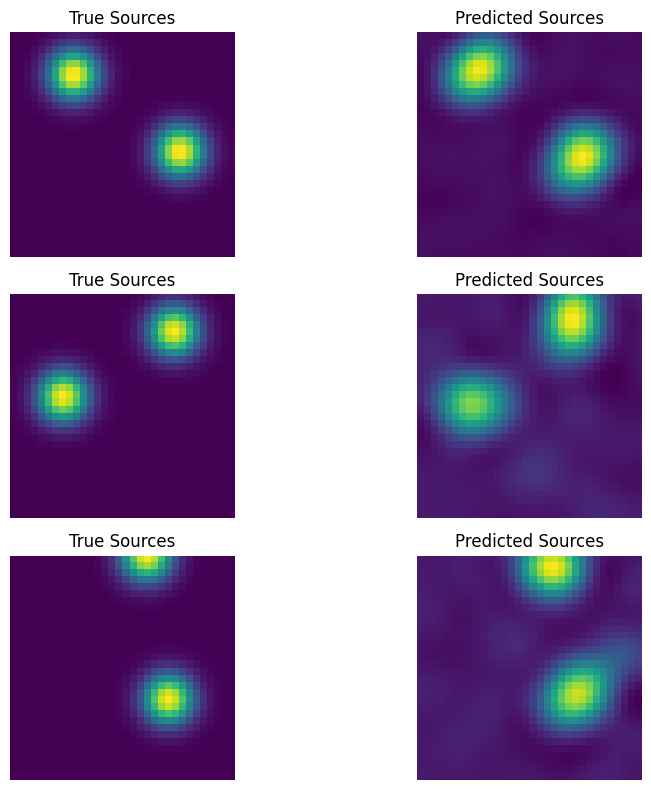

In [32]:
#visualize the results:
def visualize_dual_pred(model, loader):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.cpu().numpy()

    with torch.no_grad():
        pred = model(x).cpu().numpy()

    plt.figure(figsize=(10, 8))

    for i in range(3): # Show 3 examples
        # Truth
        plt.subplot(3, 2, 2*i+1)
        plt.imshow(y[i, 0], origin='lower')
        plt.title("True Sources")
        plt.axis('off')

        # Pred
        plt.subplot(3, 2, 2*i+2)
        plt.imshow(pred[i, 0], origin='lower')
        plt.title("Predicted Sources")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_dual_pred(model_dual, test_loader_d)

In [33]:

def get_two_peaks(heatmap, exclusion_radius=5):
    """
    Finds the (x, y) coordinates of the two brightest peaks.
    After finding the first peak, it zeros out a radius around it
    to find the second distinct peak.
    """
    # --- Peak 1 ---
    idx1 = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    peak1_y, peak1_x = idx1[0], idx1[1]

    # Mask out the region around Peak 1
    # We create a copy so we don't destroy the original for plotting
    temp_map = heatmap.copy()

    # Simple square mask (sufficient for this grid size)
    r = exclusion_radius
    y_min = max(0, peak1_y - r)
    y_max = min(heatmap.shape[0], peak1_y + r + 1)
    x_min = max(0, peak1_x - r)
    x_max = min(heatmap.shape[1], peak1_x + r + 1)

    temp_map[y_min:y_max, x_min:x_max] = 0.0

    # --- Peak 2 ---
    idx2 = np.unravel_index(np.argmax(temp_map), temp_map.shape)
    peak2_y, peak2_x = idx2[0], idx2[1]

    # Convert to Meters (Grid 100x100, 32 pixels)
    scale = 100.0 / 32.0

    loc1 = np.array([peak1_x * scale, peak1_y * scale])
    loc2 = np.array([peak2_x * scale, peak2_y * scale])

    return [loc1, loc2]

In [34]:
def evaluate_dual_model(model, loader, device, name="Test Set"):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # Predict
            outputs = model(inputs).cpu().numpy()

            # Ground truth coordinates are already in 'locs_dual' variable from generation
            # But here we only have the target heatmaps.
            # So we extract "True Peaks" from the target heatmap just like we do for prediction.
            # This ensures fair comparison.
            targets = targets.cpu().numpy()

            for i in range(len(inputs)):
                # Get Peaks
                pred_peaks = get_two_peaks(outputs[i, 0])   # [P1, P2]
                true_peaks = get_two_peaks(targets[i, 0])   # [T1, T2]

                # --- Permutation Check (The "Sophisticated" Part) ---

                # Option 1: P1->T1 and P2->T2
                dist_1 = np.linalg.norm(pred_peaks[0] - true_peaks[0])
                dist_2 = np.linalg.norm(pred_peaks[1] - true_peaks[1])
                option_a = (dist_1 + dist_2) / 2.0

                # Option 2: P1->T2 and P2->T1 (Swapped)
                dist_3 = np.linalg.norm(pred_peaks[0] - true_peaks[1])
                dist_4 = np.linalg.norm(pred_peaks[1] - true_peaks[0])
                option_b = (dist_3 + dist_4) / 2.0

                # Take the best interpretation
                best_error = min(option_a, option_b)
                errors.append(best_error)

    mean_err = np.mean(errors)
    median_err = np.median(errors)

    print(f"--- Dual Source Results ({name}) ---")
    print(f"Mean Error:   {mean_err:.4f} meters")
    print(f"Median Error: {median_err:.4f} meters")

    # Return errors for histogram plotting if needed
    return errors

# --- Usage ---
# Ensure you run this on the 'test_loader_d' (Dual Data)
_ = evaluate_dual_model(model_dual, test_loader_d, device, name="Dual Source Test")

--- Dual Source Results (Dual Source Test) ---
Mean Error:   4.3539 meters
Median Error: 3.7722 meters


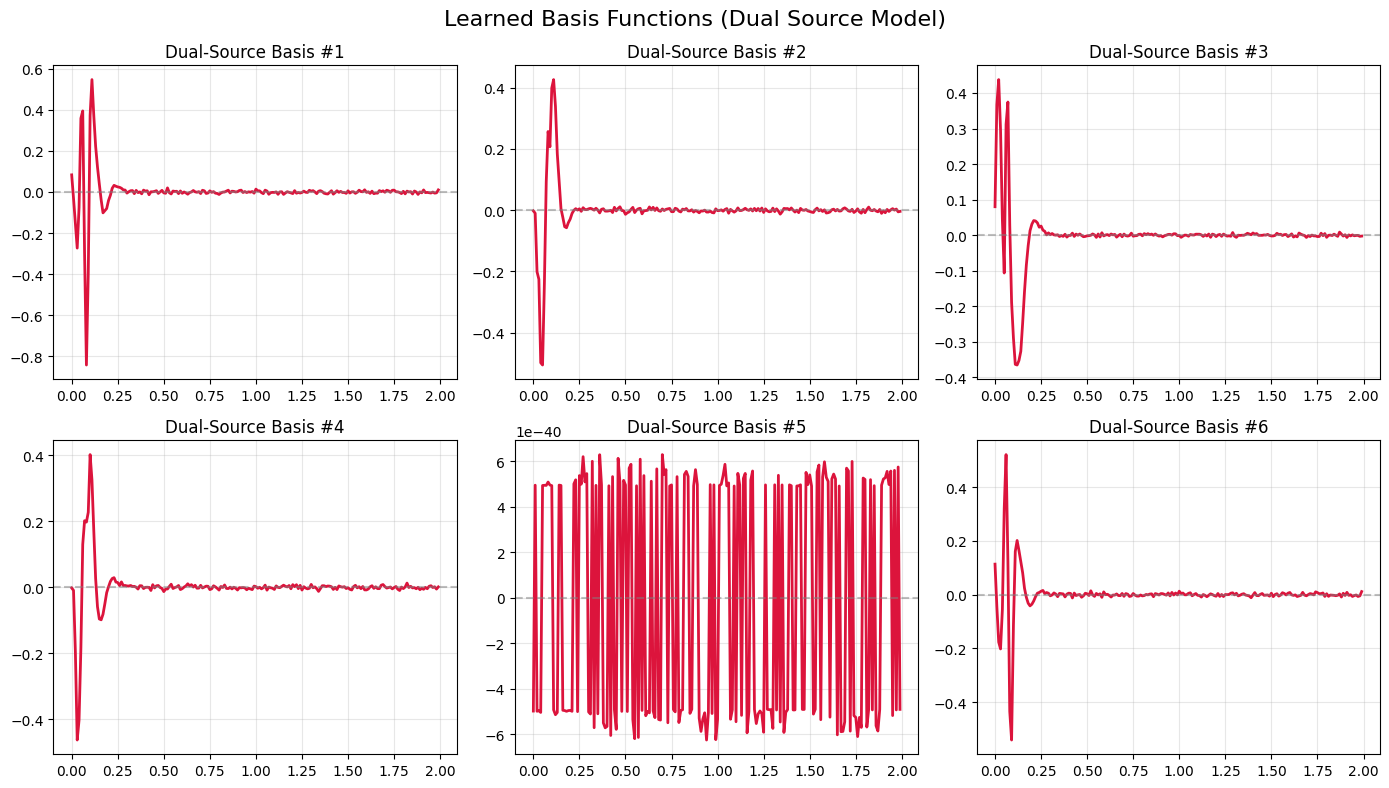

In [35]:
def visualize_dual_basis(model, num_plots=6):
    # Extract weights from the learnable transform layer
    # Shape: [Hidden_Dim, Time_Steps]
    weights = model.learnable_transform.weight.data.cpu().numpy()
    t = np.arange(200) * 0.01

    plt.figure(figsize=(14, 8))

    for i in range(num_plots):
        plt.subplot(2, 3, i+1)

        # Plot the wave
        plt.plot(t, weights[i], color='crimson', linewidth=2) # Red for dual model distinction
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)

        plt.title(f"Dual-Source Basis #{i+1}")
        plt.grid(True, alpha=0.3)

    plt.suptitle("Learned Basis Functions (Dual Source Model)", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Run Visualization ---
# Ensure you are passing the model you just trained on Dual Data
visualize_dual_basis(model_dual, num_plots=6)